In [23]:
import torch
from collections import deque
import random
import copy
from torch.autograd import Variable
import numpy as np


In [24]:
reward_pc = torch.tensor([1,3, 3 , 1,-10,2,6, 5,-5,-10])
reward_npc = torch.tensor([0,-2,-3,-1,3, 5, -3, -1,1])
#index = id-1
# action_transform
action_transform = torch.tensor([[1,3,6,7],[2,4,6,8],[1,5,6,7]])



In [25]:
dialogue_mapping_NPC = {
    1:"hello witcher",
    2:"hey kid!",
    3:"How is it going on brave witcher lord?",
    4:"Witcher can you save us from the creature thats attacking us?",
    5:"Oe witcher,  defeat a monster for me.",
    6:"Lord witcher can you save us from the creature that is attacking us?",
    7:"We don't know what monster attacked us but it was vicious. It must have to huge as it slaughtered no less than a dozen wolves. Ripped their guts out, but left lost uneaten. Howls at nighhts. People are afraid to venture into the woods at night. Please lord witcher save us from the beast.",
    8:" We don't know what monster attacked us but it was vicious. It must have to huge as it slaughtered no less than a dozen wolves. Ripped their guts out, but left lost uneaten. Howls at nighhts. People are afraid to venture into the woods at night.",
    9:"No idea what monster attacked us if i knew i would be dead. It must have to huge as it slaughtered no less than a dozen wolves. Ripped their guts out, but left lost uneaten. You sure kid like you can handle it. Howls at nighhts. People are afraid to venture into the woods at night. Sure you can take care of it we dont want any more dead bodies."
    }


dialogue_mapping_PC ={
    1:"Greetings",
    2:"Fine just busy fighting creatures from Void dimension",
    3:"Ok let me help you with it. What creature is it?",
    4:" I m gonna help you but i need to paid well for a contract like that. What kind of creature is it",
    5:"I don't have to bother with this work. farewell",
    6:" Ok, sir let me help you. What kind of creature is it.",
    7:"Sure it will take 500$",
    8:" Sure it will take 800$",
    9:"Sure it will take 1200$",
    10:"Sorry I am busy. I won't be able to do that",
   


}

In [26]:
good = False
def user_in(lister):
   
    
    for i in lister:

        print(dialogue_mapping_PC[i], i)
    x=input()
    return x

def user_good(lister):
   
    if len(lister) == 3:
        x= 3
        
    else:
        if good:
            x= 7
        else: 
            x=10

    return x

def user_bad(lister):
   
    if len(lister) == 3:
        x= 5
    else:
        x= 10 

    return x

class Environment_user():
    def __init__(self):
        self.state=(0,0) #(NPC, PC)
        self.superState = 0
    def PC_action(self,action_transformed):
        if self.superState ==0:
            return 1 
            ## code to ask input from the user
            # transform into the id

        elif self.superState == 1:
            if action_transformed == 3:
                return 2
       
            else:
                lister = [3,4,5]
                x= user_good(lister)
                return int(x)

        elif self.superState ==2:
            return 6

        elif self.superState ==3 :
            lister = [7,8,9,10]
            x= user_good(lister)
            return int(x)  

        else :
            return -1
        
    def return_reward(self):
        return reward_npc[self.state[0]-1] + reward_pc[self.state[1]-1]


    def next_state(self,action_transformed ):
        pc_action = self.PC_action(action_transformed)
        if pc_action ==-1:
            self.state =(-1,-1)
            return self.state
        self.state = (action_transformed,pc_action)
        if self.superState == 0:
            
            self.superState =1
        elif self.superState == 1:

            if action_transformed == 3:
                
                self.superState = 2
            elif pc_action == 5:
                self.superState =4

            else :
                self.superState=3


        elif self.superState ==2:
            global good
            good = True
            self.superState = 3

        elif self.superState ==3:
            self.superState = 4

        else:
            self.superState = 4
        
        return self.state
        
        
                           

        

            



        




        
        


            



        




        
        
# This is just a dummy environment

#Instantiata a environment
env = Environment_user()

In [27]:
class DQN():
    def __init__(self, n_state, n_action, n_hidden=50, lr=0.05):
        self.criterion = torch.nn.MSELoss()

        self.model = torch.nn.Sequential(
            torch.nn.Linear(n_state,n_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(n_hidden, n_action)
        )

        self.optimizer = torch.optim.Adam(self.model.parameters(),lr)

        self.model_target = copy.deepcopy(self.model)

    def target_predict(self, s):
        with torch.no_grad():
            return self.model_target(torch.Tensor(s))

    def copy_target(self):
        self.model_target.load_state_dict(self.model.state_dict())
    
    def update(self, s,y):
        y_pred = self.model(torch.Tensor(s))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def predict(self, s):
        with torch.no_grad():
            return self.model(torch.Tensor(s))


            
    def replay(self, memory, replay_size, gamma):
        if len(memory) >= replay_size:
            replay_data = random.sample(memory , replay_size)
            states =[]
            td_targets =[]
            for state, action, next_state, reward, is_done in replay_data:
                states.append(state)
                q_values = self.predict(state).tolist()
                if is_done:
                    q_values[action] = reward
                else:
                    q_values_next = self.target_predict(next_state).detach()
                    q_values[action] = reward + gamma* torch.max(q_values_next).item()

                td_targets.append(q_values)

            states = np.array(states)
            self.update(states,td_targets)


In [28]:
def gen_epsilon_greed_policy(estimator,epsilon, n_action ):
    def policy_function(state):
        if random.random() < epsilon:
            return random.randint(0,n_action-1)

        else:
            q_values = estimator.predict(state)
            return torch.argmax(q_values).item()

    return policy_function


In [29]:
n_state = 2
n_action = 3
n_hidden =50
lr = 0.3
dqn = DQN(n_state, n_action, n_hidden, lr)

memory = deque(maxlen=10000)


In [30]:
def q_learning(env, estimator , n_episode, replay_size, target_update=10, gamma=1.0, epsilon=0.1 , epsilon_decay=0.99):
    for episode in range(n_episode):
        global good
        good = False
        if episode % target_update ==0 :
            estimator.copy_target()
        policy = gen_epsilon_greed_policy(estimator, epsilon, n_action)
        env.state=(0,0)
        env.superState = 0
        state = env.state

        is_done = False
      #  print(state)

        while not is_done:
            
            action = policy(state)
          #  print(env.superState)
            transform_action = action_transform[action,env.superState]
             
           # print("npc:", transform_action)
           # print("stet",transform_action.item())enx
            print("NPC:",dialogue_mapping_NPC[transform_action.item()])
            next_state = env.next_state(transform_action)
            pc_d = dialogue_mapping_PC[next_state[1]]
            npc_d = dialogue_mapping_NPC[transform_action.item()]
            print("PC:",dialogue_mapping_PC[next_state[1]])
#            pause = input()
            reward =env.return_reward()
            total_reward_episode[episode] += reward

            #print("stet",env.superState)

            memory.append((state, action, next_state, reward, is_done))
            if env.superState == 4:
                is_done = True
            if is_done:
                print("end episode")
                break

            estimator.replay(memory, replay_size, gamma)
            state = next_state
          #  print(state)

        print('episode: {}, total reward : {}, epsilon:{}'.format(episode, total_reward_episode[episode], epsilon))
        epsilon = max(epsilon * epsilon_decay, 0.01)

In [31]:
n_episode = 500
replay_size = 10 

target_update = 10

total_reward_episode = [0] * n_episode
q_learning(env, dqn, n_episode, replay_size, target_update, gamma=0.9, epsilon = 1)


NPC: hello witcher
PC: Greetings
NPC: Witcher can you save us from the creature thats attacking us?
PC: Ok let me help you with it. What creature is it?
NPC: We don't know what monster attacked us but it was vicious. It must have to huge as it slaughtered no less than a dozen wolves. Ripped their guts out, but left lost uneaten. Howls at nighhts. People are afraid to venture into the woods at night. Please lord witcher save us from the beast.
PC: Sorry I am busy. I won't be able to do that
end episode
episode: 0, total reward : -10, epsilon:1
NPC: hello witcher
PC: Greetings
NPC: Oe witcher,  defeat a monster for me.
PC: Ok let me help you with it. What creature is it?
NPC: We don't know what monster attacked us but it was vicious. It must have to huge as it slaughtered no less than a dozen wolves. Ripped their guts out, but left lost uneaten. Howls at nighhts. People are afraid to venture into the woods at night. Please lord witcher save us from the beast.
PC: Sorry I am busy. I won't

In [32]:
total_reward_episode[-20:]

[tensor(11),
 tensor(11),
 tensor(11),
 tensor(11),
 tensor(11),
 tensor(11),
 tensor(11),
 tensor(11),
 tensor(11),
 tensor(11),
 tensor(11),
 tensor(11),
 tensor(11),
 tensor(11),
 tensor(-6),
 tensor(11),
 tensor(11),
 tensor(11),
 tensor(11),
 tensor(11)]

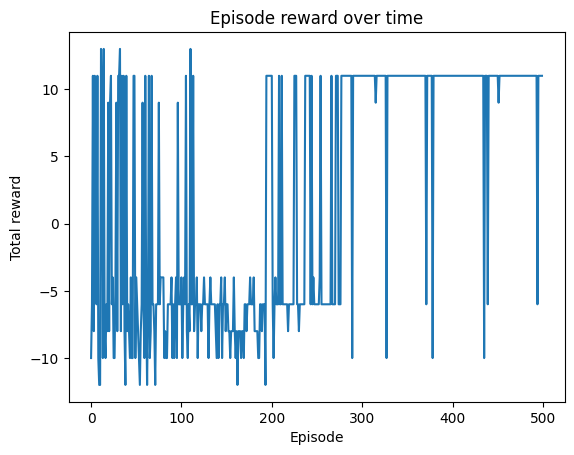

In [33]:

import matplotlib.pyplot as plt
plt.plot(total_reward_episode)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()
